In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import figure, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy.optimize import curve_fit
import radioactivedecay as rd
from mendeleev import element


plt.rc("xtick", labelsize=10, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=10, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes", grid=True, linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid", ls=":", lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=10) #Font og fontstørrelse
plt.rc("figure", figsize=(8,4), dpi=150) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major", width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major", width=1.3) #Sætter tykkelsen på xticks

In [35]:
#### paths ####  # Zn 0.37 resten cobber. 
# TODO: 1 kør med korrekt combination af mseeing 
# 2 kør med deres energi og se om de samme nuclei skabes som dem
# 3 fix sobp.dat fil og prøv at kør den treatmentplan uden collimator og med collimator 

absolute_path = os.path.abspath('').rstrip("/python_notebook")
brass20_1p25_paths = glob.glob(absolute_path + "/Full_Sim/20brass1p25mm/20brass1p25*sum.lis")
brass20_1p25_paths.sort()

# all these are dz = 50 mm 
brass1p0_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p0mm/50brass1p0*sum.lis")
brass1p0_paths.sort()
brass1p27_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p27mm/50brass1p27*sum.lis")
brass1p27_paths.sort()
brass1p5_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p5mm/50brass1p5*sum.lis")
brass1p5_paths.sort()

nbrass1p27_paths = glob.glob(absolute_path + "/Full_Sim/n50brass1p27mm/n50brass1p27*sum.lis")
nbrass1p27_paths.sort()

tungsten1p0_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p0mm/20tungsten1p0*sum.lis")
tungsten1p0_paths.sort()
tungsten1p27_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p27mm/20tungsten1p27*sum.lis")
tungsten1p27_paths.sort()
tungsten1p5_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p5mm/20tungsten1p5*sum.lis")
tungsten1p5_paths.sort()

sobp_path = absolute_path + "/sobp_format.dat"

treatmentplan_no_grid=glob.glob(absolute_path + "/correct_treatmentplan/no_grid/treatment_simulation_*_plot.dat")
treatmentplan_no_grid.sort()

treatmentplan_grid=glob.glob(absolute_path + "/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25*_plot.dat")
treatmentplan_grid.sort()

treatmentplan_grid_lis=glob.glob(absolute_path + "/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25*_sum.lis")
treatmentplan_grid_lis.sort()

test_script = glob.glob(absolute_path + "/reliability/recreation_*_sum.lis")
test_script.sort()

In [3]:
columns = ["E", "dE", "X", "Y", "FWHMx", "FWHMy", 1, 2, 3, 4, "W"]
sobp_data = pd.DataFrame(np.loadtxt(sobp_path, skiprows=2), columns=columns)
sobp_data = sobp_data.drop(columns=[1,2,3,4])

In [4]:
fmt = '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%.8e'
#np.savetxt(absolute_path + "/correct_treatmentplan/sobp.dat", sobp_data.values, delimiter=', ', fmt=fmt)

In [5]:
cool_times_dict = {
    "cool1": 300, "cool2": 900, "cool3": 3600, "cool4": 7200, "cool5": 14400, "cool6": 28800, "cool7": 57600,
    "cool8": 86400, "cool9": 115200, "cool10": 259200, "cool11": 450, "cool12": 1400, "cool13": 2500, 
    "cool14": 5400, "cool15": 10800, "cool16": 360000, "cool17": 21600, "cool18": 43200, "cool19": 150,
    "cool20": 600, "cool30": 0
}

In [6]:
def get_df_tab(path: str) -> [pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(path)
    cool_time = cool_times_dict[df.iloc[0, 0].replace(" ", "")]
    vals = df.loc[df[df.columns[0]].str.contains("#")].index.values
    df_isotopes = df.iloc[vals[0]+1:vals[1], 0].str.split(expand = True).astype(float)
    df_isomer = df.iloc[vals[1]+1:, 0].str.split(expand = True).astype(float)
    df_isotopes.columns = ["A", "Z", "Bq", "dBq"]
    df_isotopes.columns.name = cool_time
    df_isomer.columns = ["A", "Z", "m", "Bq", "dBq"]
    df_isomer.columns.name = cool_time
    return df_isotopes, df_isomer

def get_df_sum(path: str, extra = False, number = 3) -> [pd.DataFrame, pd.DataFrame]:
    skipper = 18
    if extra:
        skipper = 194
    df = pd.read_csv(path, skiprows=skipper)
    vals = df.loc[df[df.columns[0]].str.contains("A")].index.values
    for i in range(len(vals)-1):
        if vals[i+1]-vals[i] <= 1:
            continue
        columns = df.iloc[vals[i], 0].split()[3:]
        dff = df.iloc[vals[i]+1:vals[i+1], 0].str.split(expand = True).reset_index().drop("index", axis=1)
        try:
            ff = dff.loc[::2,:len(columns)].set_index(0).replace("********", "0").astype(float)
        except ValueError:
            dff = dff.drop(dff.tail(1).index)
            ff = dff.loc[::2,:len(columns)].set_index(0).replace("********", "0").astype(float)
        ff.columns = columns
        dd = df.iloc[vals[i]+1:vals[i+1], 0]
        dd = dd.str.replace("+", "", regex=True)
        dd = dd.str.replace("/", "", regex=True)
        dd = dd.str.replace("-", "", regex=True)
        dd = dd.str.replace("%", "", regex=True)
        dd = dd.str.split(expand = True).reset_index().drop("index", axis=1)
        dg = dd.loc[1::2,:len(columns)-1].astype(float)
        dg.columns = columns
        dg.index = ff.index
        if i == 0:
            tot_df = ff
            tot_df_d = dg
        else:
            tot_df = pd.concat([tot_df, ff])
            tot_df_d = pd.concat([tot_df_d, dg])
    name = cool_times_dict[f"cool{int(path.split('_')[number])-20}"]
    tot_df_d.columns.name = name
    tot_df.columns.name = name
    return tot_df, tot_df_d
    
        
    
def plot_img(df: pd.DataFrame, pivot: bool, transpose = False) -> None:
    plt.figure(figsize=(7, 5))
    plt.title(f"Cooling time in sec = {df.columns.name}")
    ax = plt.gca()
    if pivot:
        data = df.pivot_table(index='Z', columns='A', values='Bq')
    else:
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value = df.index[-1]
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value2 = df.index[-1]
        aa = pd.DataFrame(index=range(last_value+1), columns =range(last_value2+1))
        aa.iloc[df.columns.values, df.index.values] = df.transpose().values
        data = aa.fillna(0)
    if transpose:
        data = data.transpose()
    im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=0.1, vmax=10000), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.xlabel("A")
    plt.ylabel("Z")
    plt.colorbar(im, cax=cax)
    plt.show()
    return 


def find_elements(df: pd.DataFrame, threshold: float, cool_in_sec=False) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[df[i] > threshold, i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    print("Cooling time =", df.columns.name if cool_in_sec else df.columns.name/60/60,
          "Seconds" if cool_in_sec else "Hours",
          f"| Threshold = {threshold:.0f}")
    return df_return.sort_values("Bq", ascending=False)


def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[:,i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    return df_return.fillna(0)


def indv_atom(paths: list, A: str, Z: str, number=3) -> list:
    values = []
    for i in paths:
        try:
            ff1, uncb = get_df_sum(i, number=number)
            values.append(ff1.loc[A, Z].sum())
        except Exception as e:
            print("error : ", e)
            values.append(0)
    return values


def plot_spec(type_: str, A: list, Z: list, number=3, ylog=False) -> None:
    paths = type_
    times = []
    
    for path in paths:
        times.append(cool_times_dict[f"cool{int(path.split('_')[number])-20}"])
        
    data = pd.DataFrame(index=times)
    for a, z in zip(A, Z):
        data[f"{a}, {z}"] = indv_atom(type_, a, z, number=number)
    data = data.sort_index()
    for i in data.columns:
        plt.plot(data.index.values/60/60, data[i].values, label=i)
    plt.xlabel("Hours")
    plt.ylabel("Bq")
    if ylog:
        plt.yscale("log")
    plt.legend()
    plt.show()
    
    return
    

def get_df_from_data(path: str, one_dim=False) -> pd.DataFrame:
    values = np.loadtxt(path)
    columns = ["z", "value", "error"] if one_dim else ["x", "y", "value", "error"]
    df = pd.DataFrame(data=values, columns=columns)
    return df
    
    
def plot_datfile(path, onedim=False) -> None:
    df = get_df_from_data(path, onedim)
    if onedim:
        plt.errorbar(df["z"].values, df["value"].values, yerr=df["error"].values, fmt="o", markersize=4
                     , capsize=5)
        plt.show()
    else:
        data = df.pivot_table(index='x', columns='y', values='value')
        fig, ax = plt.subplots(figsize=(20, 4))
        im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=data.min().min(), vmax=data.max().max())
                       , origin='lower')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.xlabel("A")
        plt.ylabel("Z")
        plt.colorbar(im, cax=cax)
        plt.show()

        
def get_val_unc(paths, number=3):
    times = []
    sums = []
    uncs = []

    for path in paths:
        try:
            df, unc = get_df_sum(path)
            sums.append(df.sum().sum())
            times.append(cool_times_dict[f"cool{int(path.split('_')[number])-20}"])
            df_unc = (df*unc/100)**2
            uncs.append((df_unc.sum().sum())**(1/2))
        except:
            print(path)
    
    return times, sums, uncs

def get_tot_df(paths: list, number=3):
    tungsten_paths = paths
    tot_df_tungsten, extra = get_df_sum(tungsten_paths[0], number=number)
    tot_df_tungsten = sort_df(tot_df_tungsten)
    tot_unc_df = sort_df(extra)
    tot_unc_df["Bq"] = tot_unc_df["Bq"].values * tot_df_tungsten["Bq"].values / 100

    for i in range(1, len(tungsten_paths)):
        path = tungsten_paths[i]
        df, extra_unc = get_df_sum(path, number=number)
        df = sort_df(df)
        extra_unc = sort_df(extra_unc)
        extra_unc["Bq"] = extra_unc["Bq"].values * df["Bq"].values / 100
        tot_df_tungsten = pd.concat([tot_df_tungsten, df], join="inner")
        tot_unc_df = pd.concat([tot_unc_df, extra_unc], join="inner")

    tot_unc_df["Bq"] = tot_unc_df["Bq"] ** 2
    tot_unc_df = pd.pivot_table(tot_unc_df, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
    tot_unc_df["Bq"] = tot_unc_df["Bq"] ** (1/2)
    tot_unc_df = tot_unc_df.sort_index()
    df_sums_tungsten = pd.pivot_table(tot_df_tungsten, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
    df_sums_tungsten = df_sums_tungsten.sort_index()
    df_sums_tungsten["+-"] = tot_unc_df["Bq"]
    df_sums_tungsten = df_sums_tungsten.sort_values(by="Bq", ascending=False)
    return df_sums_tungsten

def get_unc_df(paths: list, number=3):
    tungsten_paths = paths
    tot_df_tungsten, extra = get_df_sum(tungsten_paths[0], number=number)
    extra = sort_df(extra)

    for i in range(1, len(tungsten_paths)):
        path = tungsten_paths[i]
        df, df_extra = get_df_sum(path, number=number)
        extra = pd.concat([extra, sort_df(df_extra)], join="inner")

    extra = pd.pivot_table(extra, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
    extra = extra.sort_values(by="Bq", ascending=False)
    extra=extra.loc[extra["Bq"] > extra.describe()["Bq"].loc["25%"]]
    return extra


def funlin(x, a, gamma):
    return a*np.exp(-gamma*x) # no offset 


xlin = np.array([300, 900, 3600, 7200,14400,28800,57600,86400,115200,259200,450,
                 1400,2500,5400,10800,360000,21600,43200,150,600])


def fit_data(df, df_uncs, guess=[7e8, 0.00009], prints = False):
    ylin = df
    yler = df_uncs
    popt, pcov = curve_fit(funlin, xlin, ylin, p0=guess, sigma=yler, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    if prints:
        print('a:',popt[0],'    gamma :',popt[1])
        print('usikkerheder:',perr)
        print("halflife = ", 1/popt[1]/60/60, " hours +-", (1/popt[1]**4*perr[1]**2)**(1/2)/60/60)       
    return popt, perr


def add_plot(xs, ys, uncs, popt, perr, label, type_ = "o"):
    
    plt.plot(xs/60/60, funlin(xs, *popt), "--", color="black")
    plt.errorbar(xlin/60/60, ys, yerr=uncs, fmt=type_, markersize=4,
                 capsize=5, label=label)

    plt.fill_between(xs/60/60, funlin(xs, popt[0]-perr[0], popt[1]+perr[1], popt[2]-perr[2]),
                     funlin(xs, popt[0]+perr[0], popt[1]-perr[1], popt[2]+perr[2]), color="lightgrey")
    return



def add_plotx(xs, ys, uncs, popt, perr, label, type_ = "o", nofunc=True):
    if nofunc:
        plt.plot(xs/60/60, funlin(xs, *popt), "--", color="black")
        plt.fill_between(xs/60/60, funlin(xs, popt[0]-perr[0], popt[1]+perr[1]),
                     funlin(xs, popt[0]+perr[0], popt[1]-perr[1]), color="lightgrey")
    plt.errorbar(np.array(xlin)/60/60, ys, yerr=uncs, fmt=type_, markersize=4,
                 capsize=5, label=label)


    return


def catch(A, Z, noread=False):
    try:
        if noread:
            output = rd.Nuclide(f'{element(Z).symbol}-{A}').half_life()
        else:
            output = rd.Nuclide(f'{element(Z).symbol}-{A}').half_life("readable")
    except:
        if noread:
            output = 1e9
        else:
            output = "No Data"
        
    return output

def catch_decay_type(A, Z):
    try:
        output = rd.Nuclide(f'{element(Z).symbol}-{A}').decay_modes()[0]
    except:
        output = "No Data"
        
    return output


def plot_branch(A, Z):
    nuc = rd.Nuclide(f'{element(Z).symbol}-{A}')
    nuc.plot()
    plt.show()
    return


def load_dat_file(path: str, columns: list):
    data = np.loadtxt(path)
    columns.append("Unc")
    columns.append("Value")
    df = pd.DataFrame(data=data, columns=columns)
    return df


def plotter_treat(path, dims, swap_dims=False, ylim=None, xlim=None):
    xs = 1
    ys = 0
    if swap_dims:
        xs = 0
        ys = 1
    df = load_dat_file(path, dims)
    data = pd.pivot_table(df, index=dims[0], columns=dims[1], values="Unc")
    fig, ax = plt.subplots(figsize=(8,4))
    im = ax.imshow(data, extent=[df[dims[xs]].min(), df[dims[xs]].max(), df[dims[ys]].max(), df[dims[ys]].min()]
                   , cmap="jet")
    ax.set_xlabel(dims[0])
    ax.set_ylabel(dims[1])
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_aspect('equal', adjustable='box')
    ax.autoscale(enable=None, axis="x", tight=True)
    ax.autoscale(enable=None, axis="y", tight=True)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    return


# Treatment plan Grid off

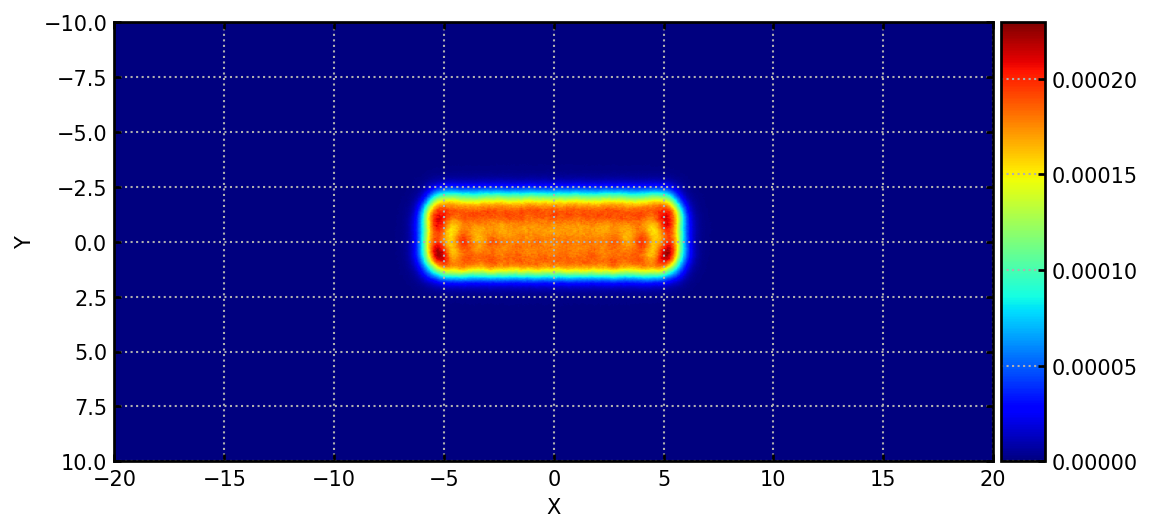

In [7]:
plotter_treat(treatmentplan_no_grid[0], ["X", "Y"])
plt.show()

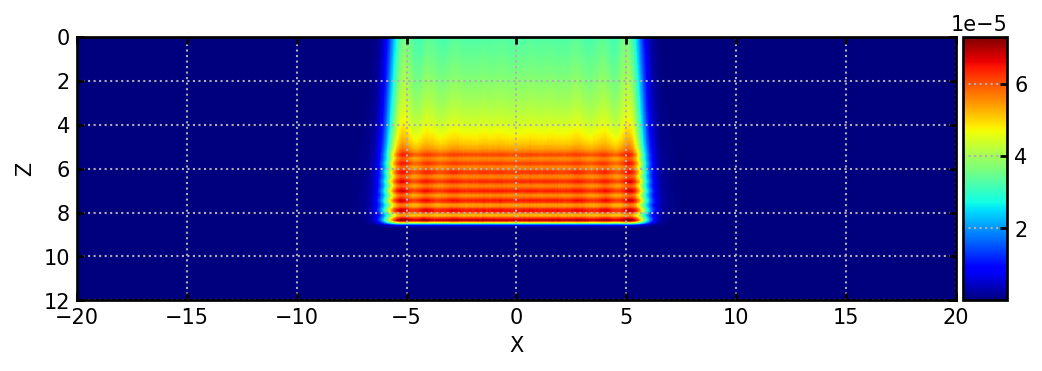

In [8]:
plotter_treat(treatmentplan_no_grid[1], ["X", "Z"], swap_dims=False)
plt.show()

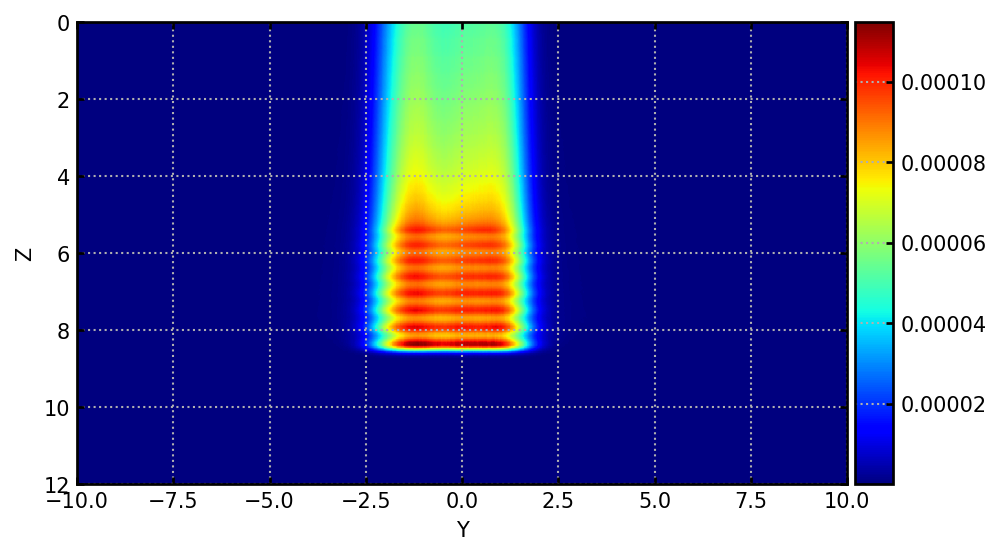

In [9]:
plotter_treat(treatmentplan_no_grid[2], ["Y", "Z"], swap_dims=False)
plt.show()

In [10]:
load_dat_file(treatmentplan_no_grid[4], ["X", "Y"])

,X,Y,Unc,Value
0,-2.5,-10.00,0.000086,18.3517
1,-2.5,-9.95,0.000079,16.6321
2,-2.5,-9.90,0.000085,15.2340
3,-2.5,-9.85,0.000084,14.7836
4,-2.5,-9.80,0.000082,10.3183
...,...,...,...,...
40496,2.5,9.80,0.000082,12.0512
40497,2.5,9.85,0.000085,17.2154
40498,2.5,9.90,0.000064,14.9023
40499,2.5,9.95,0.000066,25.5142


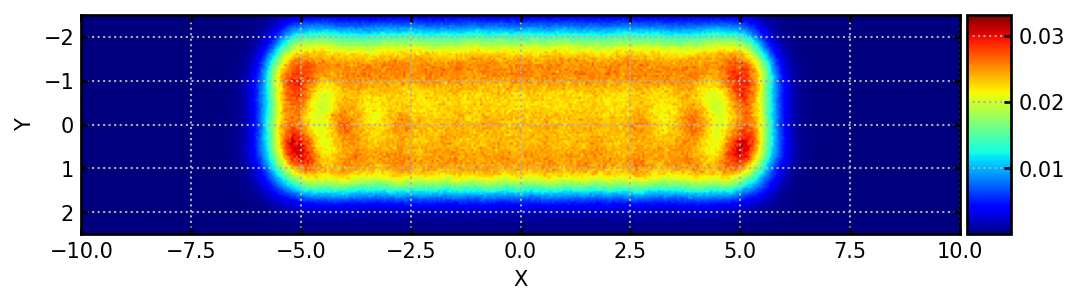

In [11]:
plotter_treat(treatmentplan_no_grid[4], ["X", "Y"], swap_dims=False)
plt.show()

# Grid On (50brass1p25mm)

In [12]:
treatmentplan_grid

['/home/msd/AU/fluka_simulations/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25_41_plot.dat',
 '/home/msd/AU/fluka_simulations/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25_42_plot.dat',
 '/home/msd/AU/fluka_simulations/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25_70_plot.dat',
 '/home/msd/AU/fluka_simulations/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25_71_plot.dat',
 '/home/msd/AU/fluka_simulations/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25_72_plot.dat',
 '/home/msd/AU/fluka_simulations/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25_73_plot.dat',
 '/home/msd/AU/fluka_simulations/correct_treatmentplan/grid_50brass1p25/treatment_grid_50brass1p25_80_plot.dat']

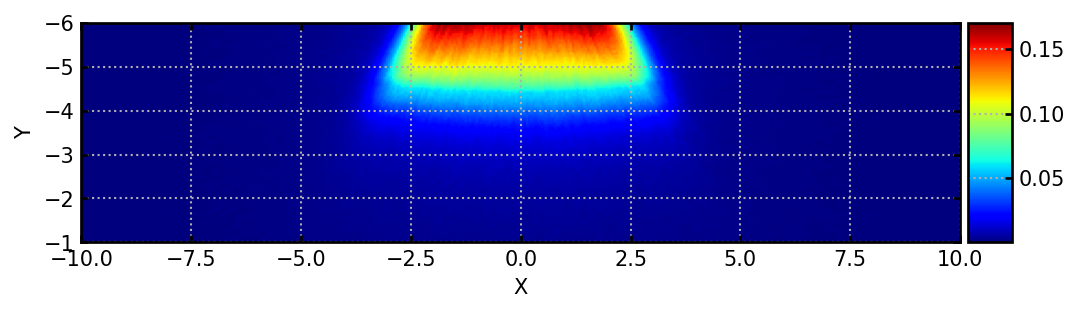

In [13]:
plotter_treat(treatmentplan_grid[0], ["X", "Y"], swap_dims=False) # in the leaf z: [-6:-1]
plt.show()

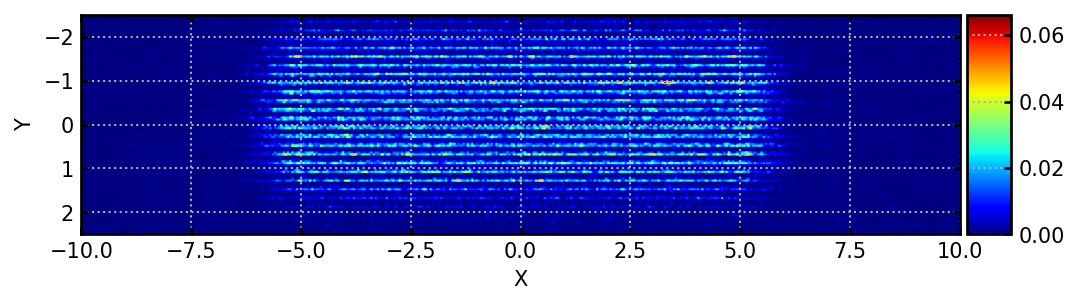

In [14]:
plotter_treat(treatmentplan_grid[1], ["X", "Y"], swap_dims=False) # before water z: [-1:0]

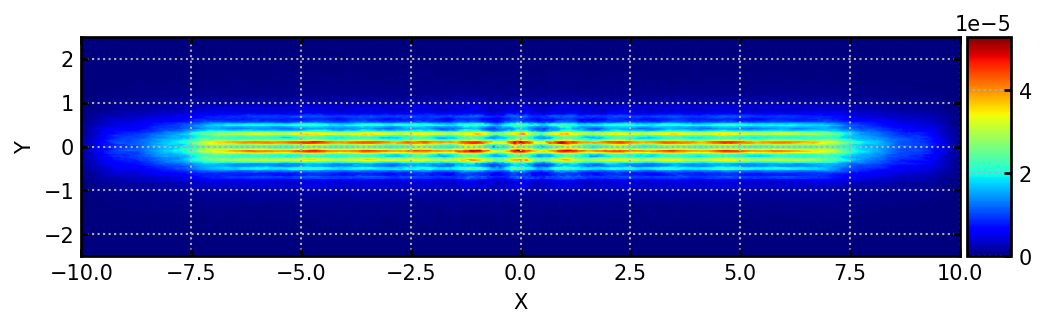

In [15]:
plotter_treat(treatmentplan_grid[2], ["X", "Y"], swap_dims=False, ylim=[-2.5, 2.5], xlim=[-10,10]) # in water z: [1:12]

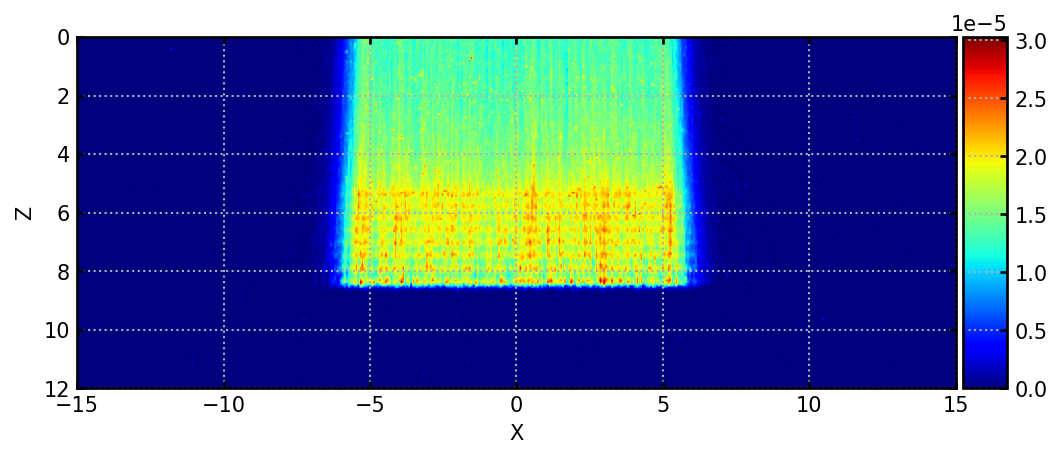

In [16]:
plotter_treat(treatmentplan_grid[3], ["X", "Z"], xlim=[-15, 15]) # in water y: [-10:10]

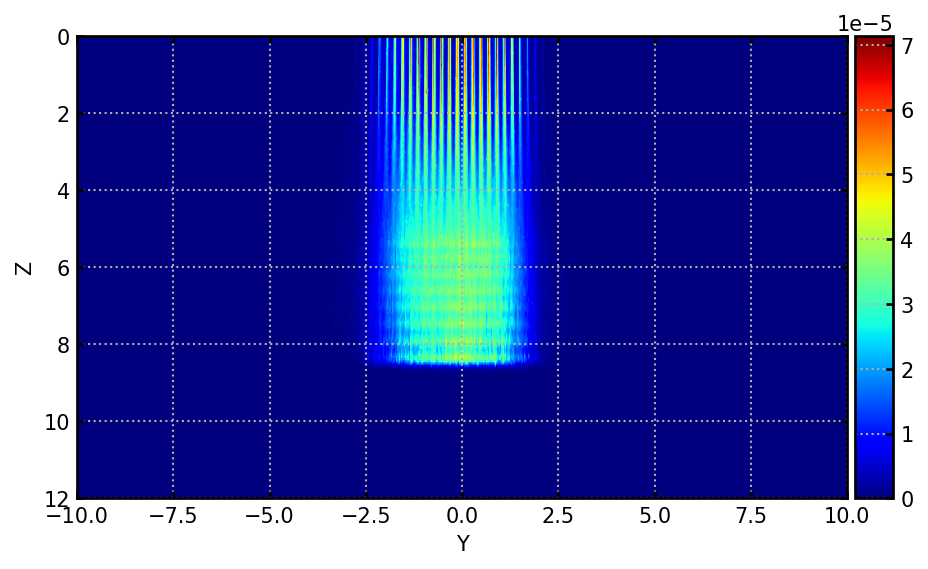

In [18]:
plotter_treat(treatmentplan_grid[4], ["Y", "Z"], swap_dims=False) # in water x: [-20:20]

# 20Brass1p25mm simulation results 

In [19]:
brass = get_tot_df(brass20_1p25_paths).reset_index()
b = brass.loc[brass["Bq"] > brass.describe()["Bq"].loc["25%"]].copy()
b["Half life"] = [catch(A, Z) for A, Z in zip(b["A"], b["Z"])]
b["decay modes"] = [catch_decay_type(A, Z) for A, Z in zip(b["A"], b["Z"])]

In [441]:
# Compare with experimental results
b.loc[(b["A"].isin(["56", "18", "22", "56", "68", "60", "89", "103"])) &
      (b["Z"].isin([27, 18, 9, 11, 25, 31, 40, 44]))].rename(columns={"Bq": "Bq/V"})

,A,Z,Bq/V,+-,Half life,decay modes
11,68,31,1.1e+03,1.3e+01,67.71 m,β+ & EC
22,56,25,9.7e+01,1.3e+00,2.5789 h,β-
42,18,9,8.2e+00,3.7e-01,109.77 m,β+ & EC
48,56,27,4.5e+00,1.3e-02,77.23 d,β+ & EC
80,60,27,8.3e-02,3.6e-04,5.2713 y,β-
94,22,11,2.1e-04,2.9e-05,2.6019 y,β+ & EC
107,22,9,1.5e-11,1.4e-11,No Data,No Data


In [442]:
b[:15].rename(columns={"Bq": "Bq/V"})  # TOP 15

,A,Z,Bq/V,+-,Half life,decay modes
0,62,29,81177.5,139.3,9.673 m,β+ & EC
1,11,6,59682.1,91.6,20.39 m,β+ & EC
2,13,7,54187.7,163.4,9.965 m,β+ & EC
3,63,30,19179.4,46.7,38.47 m,β+ & EC
4,15,8,12004.9,46.8,122.24 s,β+ & EC
5,61,29,11129.5,15.6,3.333 h,β+ & EC
6,60,29,5784.2,30.3,23.7 m,β+ & EC
7,64,29,2544.7,5.7,12.700 h,β+ & EC
8,65,31,1859.3,22.4,15.2 m,β+ & EC
9,62,30,1176.2,1.8,9.186 h,β+ & EC


# 50Brass1p27mm simulation results 

In [40]:
nbrass = get_tot_df(treatmentplan_grid_lis, number=6).reset_index()
k = nbrass.loc[nbrass["Bq"] > nbrass.describe()["Bq"].loc["25%"]].copy()
k["Half life"] = [catch(A, Z) for A, Z in zip(k["A"], k["Z"])]
k["decay modes"] = [catch_decay_type(A, Z) for A, Z in zip(k["A"], k["Z"])]

In [41]:
pd.set_option("display.precision", 1)
k[:15].rename(columns={"Bq": "Bq/V"})  # TOP 15

,A,Z,Bq/V,+-,Half life,decay modes
0,62,29,194592.8,4517.4,9.673 m,β+ & EC
1,15,8,86837.6,2762.8,122.24 s,β+ & EC
2,63,30,43243.6,737.1,38.47 m,β+ & EC
3,11,6,35653.6,902.7,20.39 m,β+ & EC
4,61,29,19450.5,371.0,3.333 h,β+ & EC
5,13,7,13453.4,486.7,9.965 m,β+ & EC
6,60,29,11790.7,879.1,23.7 m,β+ & EC
7,66,29,6005.5,283.1,5.120 m,β-
8,64,29,5557.2,52.4,12.700 h,β+ & EC
9,65,31,5484.3,460.6,15.2 m,β+ & EC


In [22]:
nbrass = get_tot_df(nbrass1p27_paths).reset_index()
k = nbrass.loc[nbrass["Bq"] > nbrass.describe()["Bq"].loc["25%"]].copy()

In [23]:
k["Half life"] = [catch(A, Z) for A, Z in zip(k["A"], k["Z"])]
k["decay modes"] = [catch_decay_type(A, Z) for A, Z in zip(k["A"], k["Z"])]

In [438]:
# Compare with experimental results
k.loc[(k["A"].isin(["56", "41", "18", "22", "56", "68", "60"])) &
      (k["Z"].isin([27, 18, 9, 11, 25, 31]))].rename(columns={"Bq": "Bq/V"})

,A,Z,Bq/V,+-,Half life,decay modes
10,68,31,5.4e+02,4.7e+00,67.71 m,β+ & EC
20,56,25,4.1e+01,1.2e+00,2.5789 h,β-
37,18,9,4.5e+00,3.2e-01,109.77 m,β+ & EC
46,56,27,1.9e+00,2.1e-03,77.23 d,β+ & EC
63,41,18,2.2e-01,6.4e-02,109.61 m,β-
77,60,27,4.1e-02,7.5e-05,5.2713 y,β-
93,22,11,4.1e-05,9.1e-06,2.6019 y,β+ & EC


In [439]:
pd.set_option("display.precision", 1)
k[:15].rename(columns={"Bq": "Bq/V"})  # TOP 15

,A,Z,Bq/V,+-,Half life,decay modes
0,62,29,37997.0,32.6,9.673 m,β+ & EC
1,11,6,20122.0,69.5,20.39 m,β+ & EC
2,13,7,18614.2,32.1,9.965 m,β+ & EC
3,63,30,9100.5,15.8,38.47 m,β+ & EC
4,61,29,5041.1,7.1,3.333 h,β+ & EC
5,15,8,4234.4,8.3,122.24 s,β+ & EC
6,60,29,2606.5,21.5,23.7 m,β+ & EC
7,64,29,1263.4,2.2,12.700 h,β+ & EC
8,65,31,951.0,6.5,15.2 m,β+ & EC
9,62,30,546.2,1.9,9.186 h,β+ & EC


# 20Tungsten1p27mm simulation results 


In [30]:
tungsten = get_tot_df(tungsten1p27_paths).reset_index()
t = tungsten.loc[tungsten["Bq"] > tungsten.describe()["Bq"].loc["25%"]].copy()
t["Half life"] = [catch(A, Z) for A, Z in zip(t["A"], t["Z"])]

In [31]:
t["decay modes"] = [catch_decay_type(A, Z) for A, Z in zip(t["A"], t["Z"])]

In [32]:
# Compare with experimental results
pd.set_option("display.precision", 2)

t.loc[(t["A"].isin(["84", "87", "88", "97", "7", "125", "126", "139","183", "211", "214", "219", "22", "68",
                    "18"])) 
      &(t["Z"].isin([35, 36, 4, 41, 53, 54, 58, 56, 75, 83, 86, 11, 31, 9]))].rename(columns={"Bq": "Bq/V"})

,A,Z,Bq/V,+-,Half life,decay modes
40,183,75,1.15e+07,20592.69,70.0 d,EC
43,18,9,8.51e+06,376638.90,109.77 m,β+ & EC
47,7,4,4.40e+06,4925.45,53.22 d,EC
69,97,41,9.42e+05,125730.48,72.1 m,β-
71,84,35,7.80e+05,64039.84,31.80 m,β-
114,87,36,6.19e+04,19327.13,76.3 m,β-
192,22,11,1.06e+01,2.35,2.6019 y,β+ & EC


In [33]:
t.drop_duplicates("decay modes")

,A,Z,Bq,+-,Half life,decay modes
0,179,75,2.51e+10,5.81e+07,19.5 m,β+ & EC
4,179,74,1.83e+10,2.92e+07,37.05 m,EC
5,177,75,1.69e+10,2.75e+07,No Data,No Data
21,187,74,3.17e+08,3.77e+05,23.72 h,β-


In [34]:
pd.set_option("display.precision", 1)
# t["+-"] = t["+-"]/t["Bq"]*100
t[:15].rename(columns={"Bq": "Bq/V"}) # Top 15

,A,Z,Bq/V,+-,Half life,decay modes
0,179,75,2.5e+10,2.3e-01,19.5 m,β+ & EC
1,15,8,2.4e+10,3.2e-01,122.24 s,β+ & EC
2,180,75,2.2e+10,2.4e-01,2.44 m,β+ & EC
3,178,75,2.0e+10,8.2e-02,13.2 m,β+ & EC
4,179,74,1.8e+10,1.6e-01,37.05 m,EC
5,177,75,1.7e+10,1.6e-01,No Data,No Data
6,11,6,1.0e+10,1.9e-01,20.39 m,β+ & EC
7,176,75,9.6e+09,1.9e-01,No Data,No Data
8,177,74,5.2e+09,8.9e-02,132 m,β+ & EC
9,175,75,5.1e+09,2.4e-01,No Data,No Data


In [435]:
pd.set_option("display.precision", 1)
t[:15].rename(columns={"Bq": "Bq/V"}) # Top 15

,A,Z,Bq/V,+-,Half life,decay modes
0,11,6,54093.2,62.3,20.39 m,β+ & EC
1,179,75,50476.3,97.5,19.5 m,β+ & EC
2,13,7,48993.3,147.6,9.965 m,β+ & EC
3,179,74,44523.1,51.9,37.05 m,EC
4,178,75,38509.5,142.4,13.2 m,β+ & EC
5,177,75,32317.7,118.4,No Data,No Data
6,180,75,23064.6,70.0,2.44 m,β+ & EC
7,176,75,13621.8,53.1,No Data,No Data
8,177,74,13119.4,30.0,132 m,β+ & EC
9,15,8,11032.6,64.5,122.24 s,β+ & EC


## Possible braches tungsten

In [342]:
exx = pd.DataFrame(columns=["A", "Z"])

In [358]:
Z = [73]
A = ["172", "173", "174", "175", "176", "177", "178", "180", "182", "183", "184"]

In [359]:

for a in A:
    exx = pd.concat([exx, pd.DataFrame([[a,73]], columns=exx.columns)], ignore_index=True)

In [374]:
exx =exx.drop(columns="Half life")

In [375]:
exx["Half life"] = [catch(A, Z, True) for A, Z in zip(exx["A"], exx["Z"])]

In [377]:
exx.sort_values(by="Half life")

,A,Z,Half life
14,178,73,5.6e+02
2,178,75,7.9e+02
3,179,75,1.2e+03
8,172,73,2.2e+03
10,174,73,4.1e+03
9,173,73,1.1e+04
12,176,73,2.9e+04
15,180,73,2.9e+04
18,184,73,3.1e+04
11,175,73,3.8e+04


# Reliablity - Brass activation comparison

In [254]:
tbrass = get_tot_df(test_script, number=2).reset_index()
tb = tbrass.loc[tbrass["Bq"] > tbrass.describe()["Bq"].loc["25%"]].copy()
tb["Half life"] = [catch(A, Z) for A, Z in zip(tb["A"], tb["Z"])]

In [329]:
def locater(df, A, Z):
    d = pd.DataFrame(columns=["Bq"])
    for a, z in zip(A, Z):
        print(a,z)
        d = d.append(df.loc[(df["A"]==a) & (df["Z"]==b)].values[0]) 
    return d

In [266]:
As = ["62", "59", "58", "63", "66", "61", "60", "64","57", "63", "63", "61", "53"]
Zs = [29, 29,29,30,29,30,29,31,25,31,27,29,26]
len(As), len(Zs)

(13, 13)

In [335]:
df1 = tb.loc[(tb["A"]==As[0]) & (tb["Z"]==Zs[0])].copy()
for A, Z in zip(As[1:], Zs[1:]):
    df1 = pd.concat([df1, tb.loc[(tb["A"]==A) & (tb["Z"]==Z)]], join="inner")

In [337]:
df1.rename(columns={"Bq": "Bq/V"})

,A,Z,Bq/V,+-,Half life
0,62,29,2.1e+08,9.0e+04,9.673 m
10,59,29,1.8e+06,2.1e+04,81.5 s
558,58,29,4.2e-08,2.2e-09,No Data
1,63,30,2.9e+07,3.0e+04,38.47 m
2,66,29,2.1e+07,6.1e+04,5.120 m
12,61,30,1.6e+06,2.5e+04,89.1 s
4,60,29,9.6e+06,1.4e+04,23.7 m
6,64,31,3.5e+06,2.7e+04,2.627 m
25,57,25,6.7e+05,9.4e+03,85.4 s
59,63,31,1.3e+05,1.5e+03,No Data


In [257]:
tb[:15].rename(columns={"Bq": "Bq/V"})

,A,Z,Bq/V,+-,Half life
0,62,29,2.1e+08,90234.1,9.673 m
1,63,30,2.9e+07,30309.4,38.47 m
2,66,29,2.1e+07,60657.2,5.120 m
3,61,29,1.6e+07,8842.7,3.333 h
4,60,29,9.6e+06,14400.8,23.7 m
5,64,29,8.8e+06,2193.5,12.700 h
6,64,31,3.5e+06,26817.0,2.627 m
7,53,26,3.1e+06,17536.4,8.51 m
8,65,31,2.2e+06,6982.4,15.2 m
9,197,82,2.1e+06,7494.1,8 m


In [399]:
ntimes_brass_27, nsums_brass_27, nunc_sums_brass_27 = get_val_unc(nbrass1p27_paths)
tungsten_t, tungsten_sums_27, unc_tungsten_sums_27 = get_val_unc(tungsten1p27_paths)
ntimes_brass_25, nsums_brass_25, nunc_sums_brass_25 = get_val_unc(brass20_1p25_paths)

In [400]:
popt_tungsten_27, perr_tungsten_27 = fit_data(tungsten_sums_27, unc_tungsten_sums_27, prints=True)
npopt_brass_27, nperr_brass_27 = fit_data(nsums_brass_27, nunc_sums_brass_27, guess=[0.5, 9e-10], prints=True)
npopt_brass_25, nperr_brass_25 = fit_data(nsums_brass_25, nunc_sums_brass_25, guess=[0.5, 9e-10], prints=True)


a: 48296.078643886576     gamma : 0.00033729705957426004
usikkerheder: [5.01725410e+01 2.76693153e-07]
halflife =  0.8235404664612015  hours +- 0.0006755706932466481
a: 18798.094732819613     gamma : 0.0005268877086309311
usikkerheder: [2.18949377e+01 4.65896030e-07]
halflife =  0.527204892479951  hours +- 0.0004661764972077725
a: 43440.206806437905     gamma : 0.0005382057652758088
usikkerheder: [5.62549611e+01 4.78981551e-07]
halflife =  0.5161181757973697  hours +- 0.0004593244817646347


a: 48296.078643886576     gamma : 0.00033729705957426004
usikkerheder: [5.01725410e+01 2.76693153e-07]
halflife =  0.8235404664612015  hours +- 0.0006755706932466481
a: 18798.094732819613     gamma : 0.0005268877086309311
usikkerheder: [2.18949377e+01 4.65896030e-07]
halflife =  0.527204892479951  hours +- 0.0004661764972077725
a: 43440.206806437905     gamma : 0.0005382057652758088
usikkerheder: [5.62549611e+01 4.78981551e-07]
halflife =  0.5161181757973697  hours +- 0.0004593244817646347


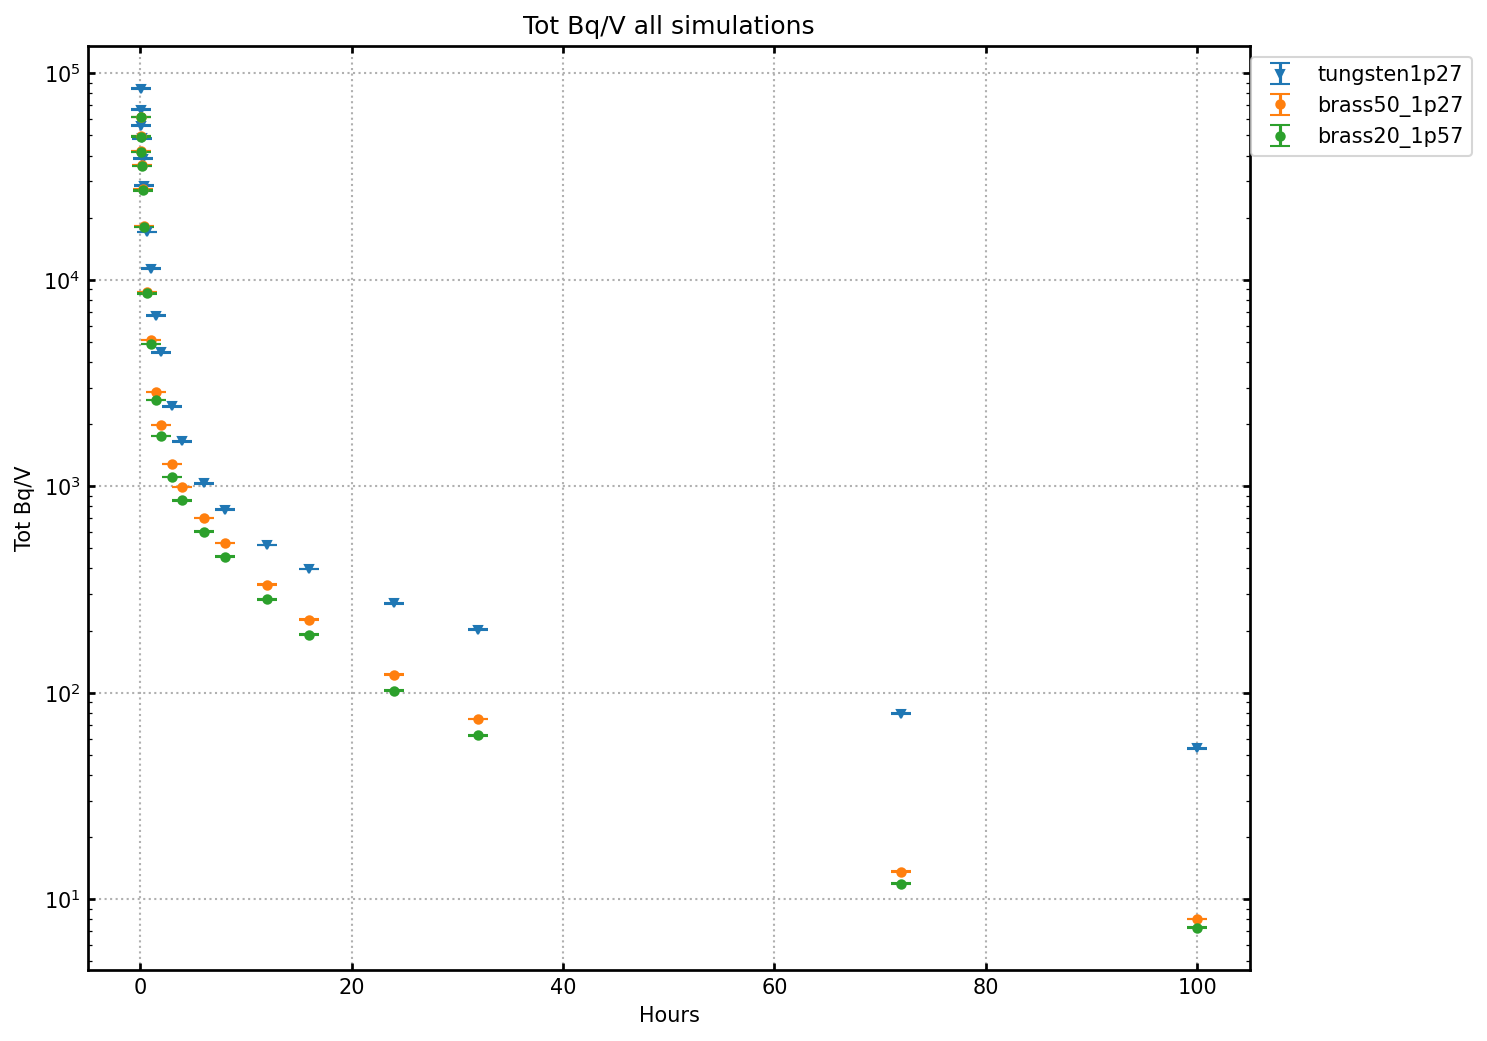

In [402]:

xs = np.linspace(100, 4e5, 20000)
plt.rc("figure", figsize=(10,8), dpi=150)


popt_tungsten_27, perr_tungsten_27 = fit_data(tungsten_sums_27, unc_tungsten_sums_27, prints=True)
npopt_brass_27, nperr_brass_27 = fit_data(nsums_brass_27, nunc_sums_brass_27, guess=[0.5, 9e-10], prints=True)
npopt_brass_25, nperr_brass_25 = fit_data(nsums_brass_25, nunc_sums_brass_25, guess=[0.5, 9e-10], prints=True)


add_plotx(xs, tungsten_sums_27, unc_tungsten_sums_27, popt_tungsten_27, perr_tungsten_27, "tungsten1p27"
          , 'v', nofunc=False) 
add_plotx(xs, np.array(nsums_brass_27)*5/2
          , nunc_sums_brass_27, npopt_brass_27, nperr_brass_27, "brass50_1p27", nofunc=False) 
add_plotx(xs, np.array(nsums_brass_25)
          , nunc_sums_brass_25, npopt_brass_25, nperr_brass_25, "brass20_1p57", nofunc=False)



plt.title("Tot Bq/V all simulations")
plt.xlabel("Hours")
plt.ylabel("Tot Bq/V")
plt.yscale("log")
#plt.xscale("log")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.show()

#### Halflife:  (181, 74) = 121.2 days | (178, 74) = 21.6 days | (177, 73) = 56.56 hours


In [230]:
df_tester = get_tot_df(test_script, number=2)
df_tester[df_tester.values > df_tester.max()[0]/10]

,,Bq,+-
A,Z,,
62,29,4.0e-02,1.7e-05
63,30,5.5e-03,5.8e-06


In [231]:
test1, ff2 = get_df_sum(test_script[18], number=2)
find_elements(test1, test1.max().mean()*5, cool_in_sec=True)

Cooling time = 150 Seconds | Threshold = 0


,A,Z,Bq
1,62,29,1.0e-02
0,66,29,1.4e-03
2,63,30,8.5e-04


In [232]:
df_tester[df_tester.values > df_tester.max()[0]/10]

,,Bq,+-
A,Z,,
62,29,4.0e-02,1.7e-05
63,30,5.5e-03,5.8e-06


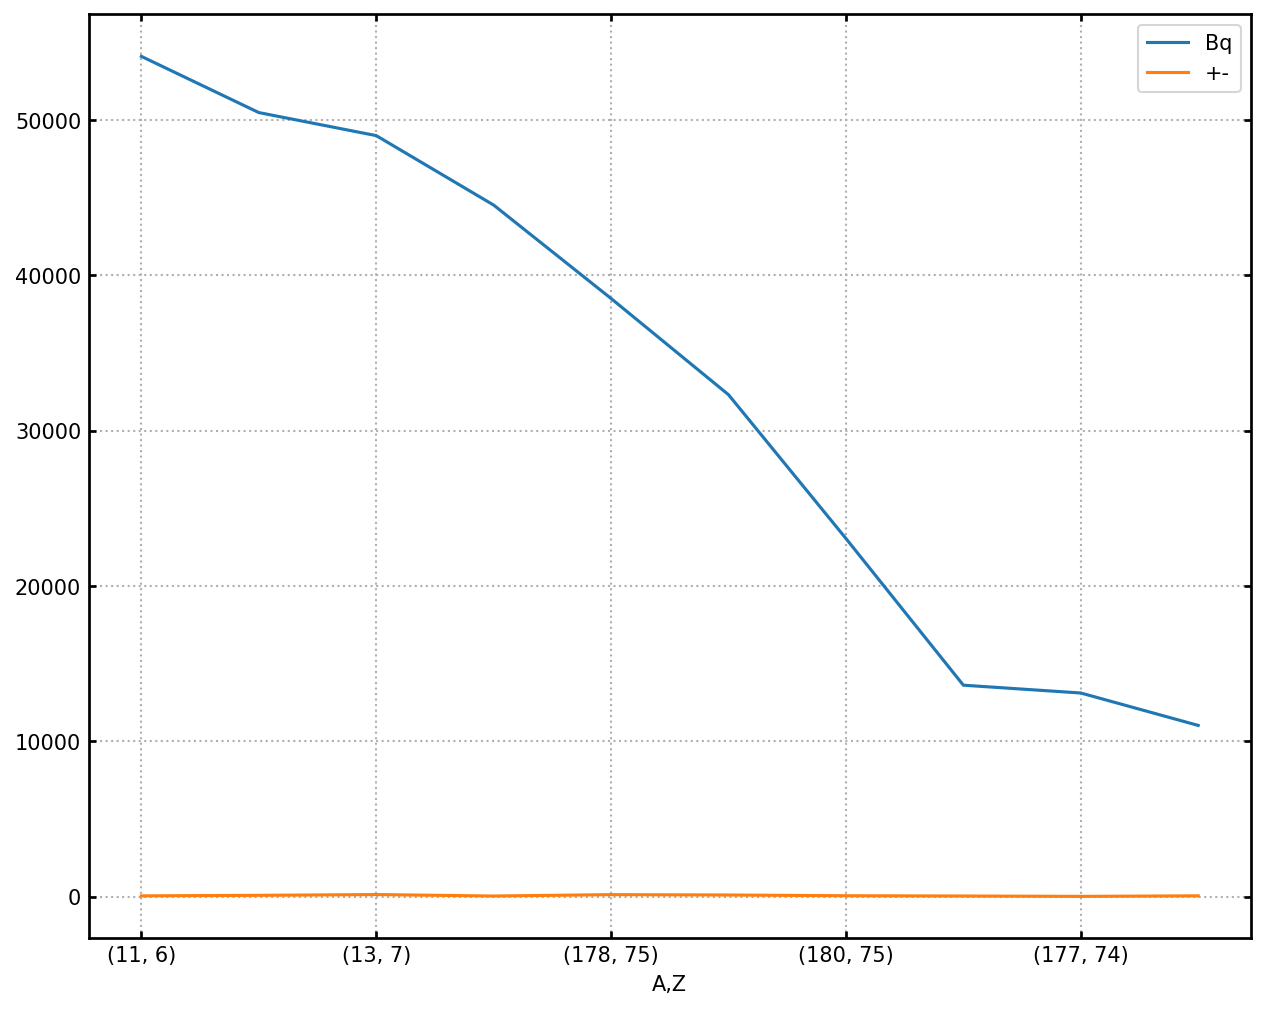

,,Bq,+-
A,Z,,
11,6,54093.2,62.3
179,75,50476.3,97.5
13,7,48993.3,147.6
179,74,44523.1,51.9
178,75,38509.5,142.4
177,75,32317.7,118.4
180,75,23064.6,70.0
176,75,13621.8,53.1
177,74,13119.4,30.0


In [233]:
df_sums_tungsten_27 = get_tot_df(tungsten1p27_paths)
df_sums_tungsten_27[:10].plot()
plt.show()
df_sums_tungsten_27[:10]

#### Halflife:  (64, 29) = 12.7 hours | (62, 29) = 9.67 min | (58, 27) = 70.86 days | (7, 4) = 53.22 d


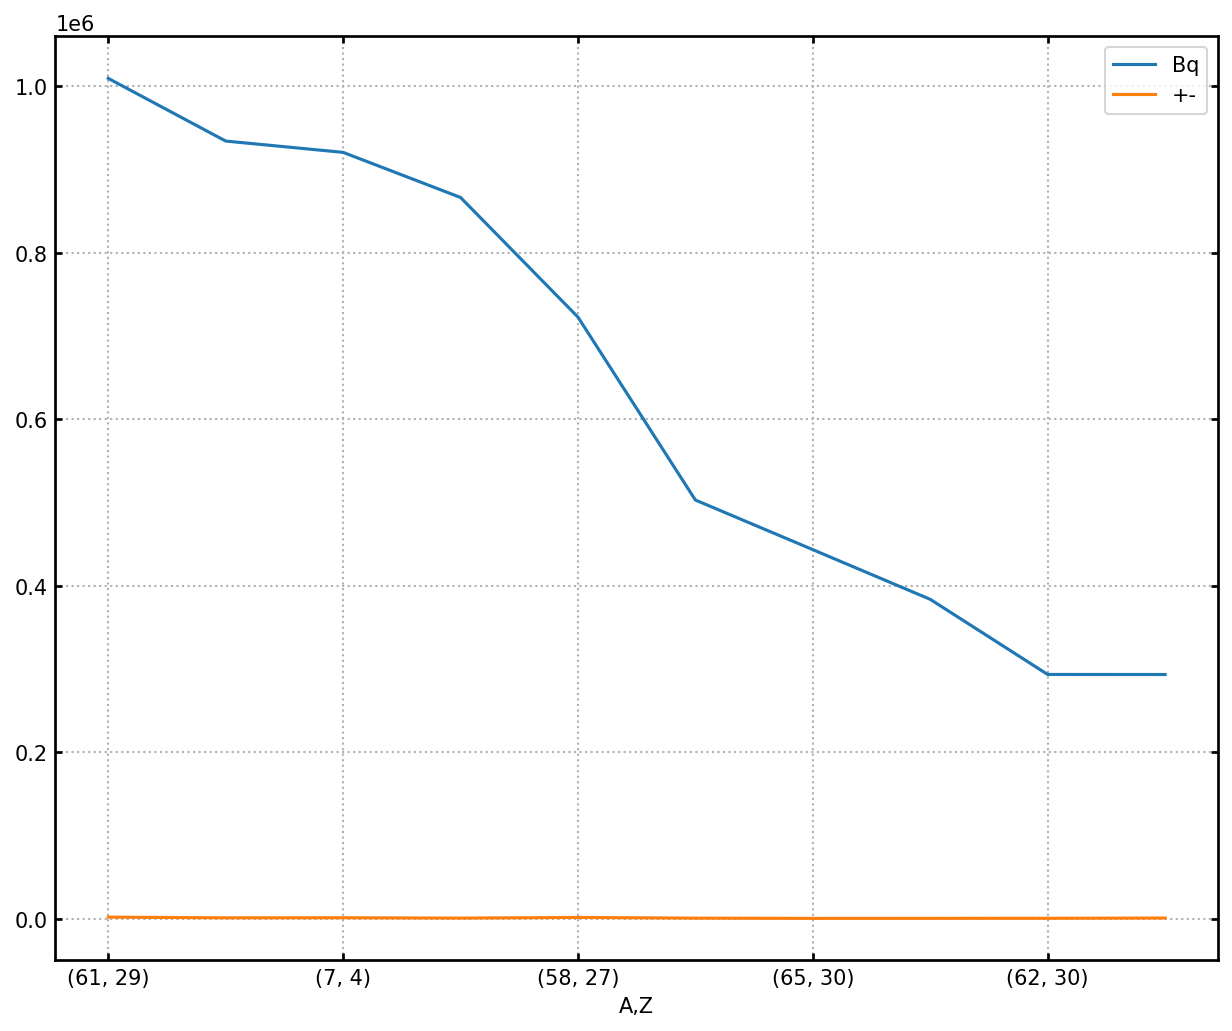

,,Bq,+-
A,Z,,
61,29,1.0e+06,1983.0
64,29,9.3e+05,1158.4
7,4,9.2e+05,1235.5
62,29,8.7e+05,815.3
58,27,7.2e+05,1616.5
11,6,5.0e+05,772.0
65,30,4.4e+05,495.9
63,30,3.8e+05,534.0
62,30,2.9e+05,597.0


In [234]:
df_sums_brass_27 = get_tot_df(brass1p27_paths)
df_sums_brass_27[:10].plot()
plt.show()
df_sums_brass_27[:10]

from experiment (confirmed, how much), F-18 (c, low), K-40 (background and maybe some created), ZR-89 (n)

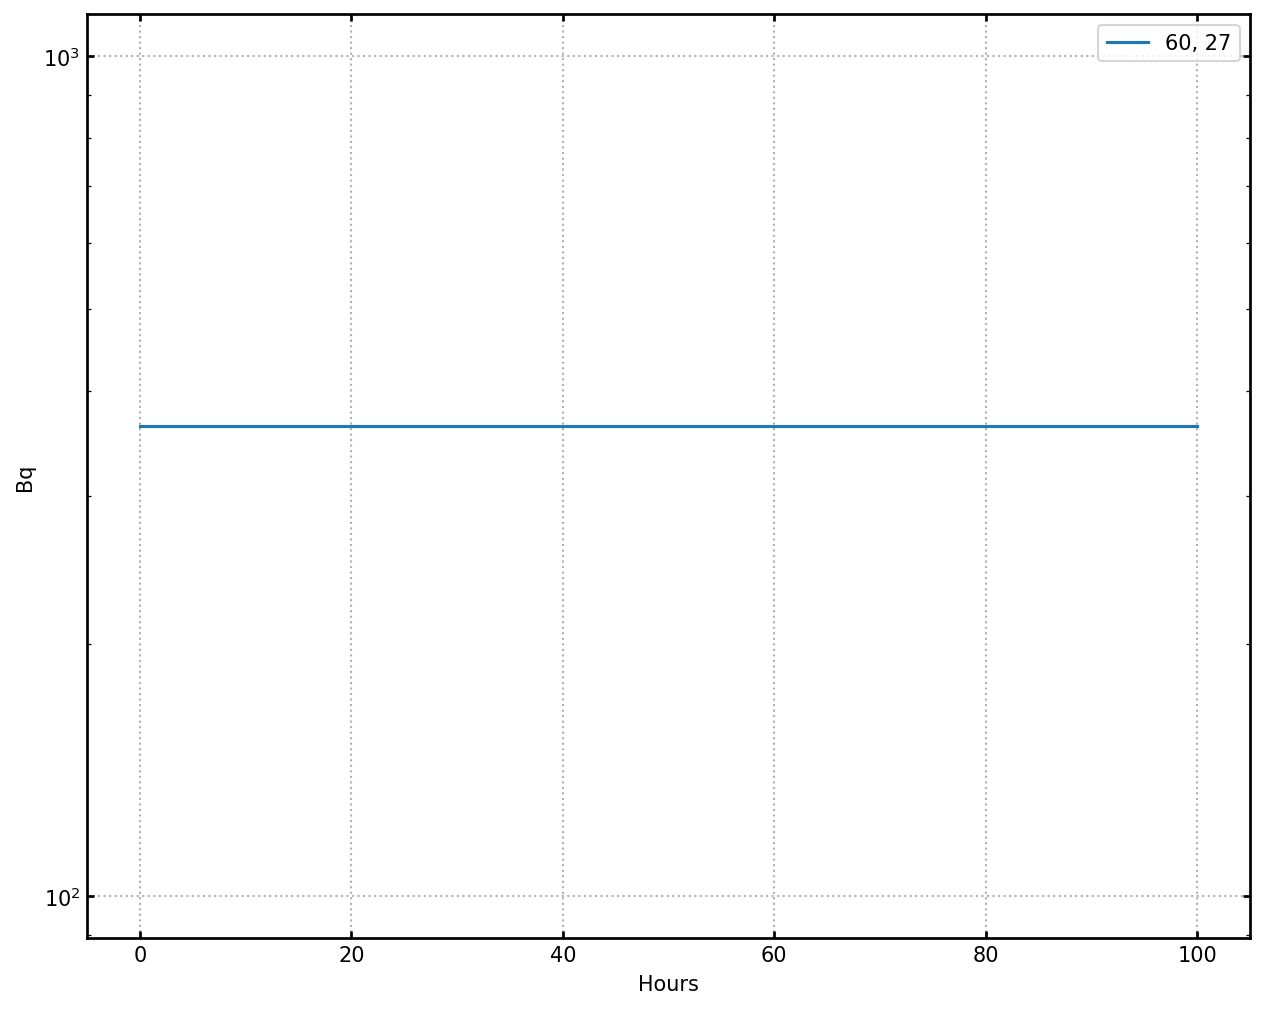

In [235]:
plot_spec(brass1p27_paths, ["60"], ["27"], ylog=True)

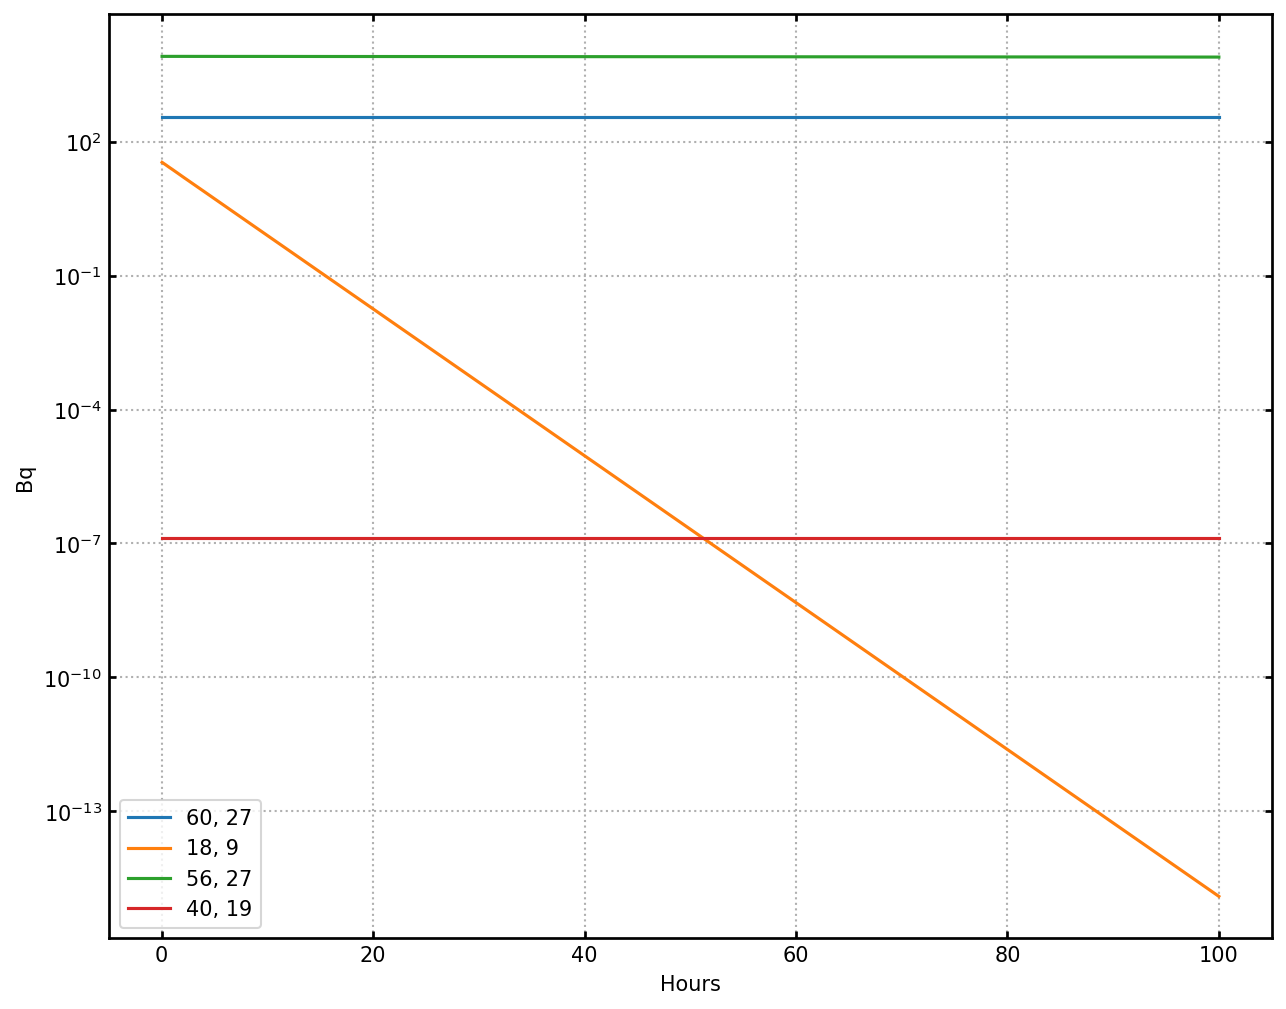

In [236]:
plot_spec(brass1p27_paths, ["60", "18", "56", "40"], ["27", "9", "27", "19"], ylog=True)

In [237]:
ff1, ff2 = get_df_sum(brass1p27_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 32947


,A,Z,Bq
1,7,4,43900.0
0,58,27,35000.0


In [238]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 6


,A,Z,Bq
0,177,73,21.5
1,178,74,8.8
2,181,75,6.8


In [239]:
ff1, ff2 = get_df_sum(brass1p27_paths[8])
find_elements(ff1, ff1.max().mean(), True)

Cooling time = 115200 Seconds | Threshold = 3817


,A,Z,Bq
6,7,4,45600.0
0,58,27,35900.0
4,65,30,22100.0
1,57,27,14600.0
3,64,29,11600.0
2,56,27,8120.0
5,67,31,6910.0


In [240]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[18])
ff1 = find_elements(ff1, ff1.max().mean(), True)
len(ff1), ff1

Cooling time = 150 Seconds | Threshold = 694


(12,
       A   Z       Bq
 10   13   7  12600.0
 3   180  75  12200.0
 9    11   6  10500.0
 4   179  75   9940.0
 5   178  75   8820.0
 6   177  75   7230.0
 11   15   8   6480.0
 7   176  75   4720.0
 0   179  74   4530.0
 8   175  75   2400.0
 2   175  74   1100.0
 1   177  74    940.0)

In [241]:
tungsten_t, tungsten_sums_27, unc_tungsten_sums_27 = get_val_unc(tungsten1p27_paths)
tungsten_t1, tungsten_sums_0, unc_tungsten_sums_0 = get_val_unc(tungsten1p0_paths)
tungsten_t2, tungsten_sums_5, unc_tungsten_sums_5 = get_val_unc(tungsten1p5_paths)

times_brass_27, sums_brass_27, unc_sums_brass_27 = get_val_unc(brass1p27_paths)
times_brass20_25, sums_brass20_25, unc_sums_brass20_25 = get_val_unc(brass20_1p25_paths)
times_brass_0, sums_brass_0, unc_sums_brass_0 = get_val_unc(brass1p0_paths)
times_brass_5, sums_brass_5, unc_sums_brass_5 = get_val_unc(brass1p5_paths)

In [242]:
popt_tungsten_27, perr_tungsten_27 = fit_data(tungsten_sums_27, unc_tungsten_sums_27, prints=True)
popt_tungsten_0, perr_tungsten_0 = fit_data(tungsten_sums_0, unc_tungsten_sums_0, prints=True)
popt_tungsten_5, perr_tungsten_5 = fit_data(tungsten_sums_5, unc_tungsten_sums_5, prints=True)

popt_brass_27, perr_brass_27 = fit_data(sums_brass_27, unc_sums_brass_27, prints=True)
popt_brass20_25, perr_brass20_25 = fit_data(sums_brass20_25, unc_sums_brass20_25, prints=True)
popt_brass_0, perr_brass_0 = fit_data(sums_brass_0, unc_sums_brass_0, prints=True)
popt_brass_5, perr_brass_5 = fit_data(sums_brass_5, unc_sums_brass_5, prints=True)

a: 48296.078643886576     gamma : 0.00033729705957426004
usikkerheder: [5.01725410e+01 2.76693153e-07]
halflife =  0.8235404664612015  hours +- 0.0006755706932466481
a: 2344501.6111004376     gamma : 3.84740207578865e-06
usikkerheder: [1.13948731e+03 7.95051776e-09]
halflife =  72.19879084793553  hours +- 0.1491961998417464
a: 2648439.357188639     gamma : 3.623639488536382e-06
usikkerheder: [1.00807102e+03 5.70417309e-09]
halflife =  76.65712294408584  hours +- 0.120670254192198
a: 497788.61527679936     gamma : 1.8266762334055214e-05
usikkerheder: [3.35868669e+02 3.49956121e-08]
halflife =  15.206733010365458  hours +- 0.029133183007316665
a: 0.09649771852670508     gamma : 0.0005377577230757584
usikkerheder: [1.24923080e-04 4.78356762e-07]
halflife =  0.5165481886322346  hours +- 0.0004594900422256688
a: 333314.21746156627     gamma : 1.2997221496431129e-05
usikkerheder: [3.59990763e+02 4.92212837e-08]
halflife =  21.372089246463336  hours +- 0.08093742718963724
a: 488730.4307424587

In [243]:
xs = np.linspace(100, 4e5, 2000)
plt.rc("figure", figsize=(10,8), dpi=150)

add_plot(xs, tungsten_sums_0, unc_tungsten_sums_0, popt_tungsten_0, perr_tungsten_0, "tungsten1p0", '<') 
add_plot(xs, tungsten_sums_27, unc_tungsten_sums_27, popt_tungsten_27, perr_tungsten_27, "tungsten1p27", 'v') 
add_plot(xs, tungsten_sums_5, unc_tungsten_sums_5, popt_tungsten_5, perr_tungsten_5, "tungsten1p5", 'v') 
add_plot(xs, sums_brass20_25, unc_sums_brass20_25, popt_brass20_25, perr_brass20_25, "brass20_1p25") 
add_plot(xs, sums_brass_0, unc_sums_brass_0, popt_brass_0, perr_brass_0, "brass1p0")
add_plot(xs, sums_brass_27, unc_sums_brass_27, popt_brass_27, perr_brass_27, "brass1p27") 
add_plot(xs, sums_brass_5, unc_sums_brass_5, popt_brass_5, perr_brass_5, "brass1p5", '<') 


plt.title("Tot Bq all simulations")
plt.xlabel("Hours")
plt.ylabel("Tot Bq")
#plt.yscale("log")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
ff1, ff2 = get_df_sum(brass1p27_paths[4])
plot_img(ff1, False, True)

In [ ]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[4])
plot_img(ff1, False, True)